In [1]:
import os
import sys

parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from utils.mobility_data_manager import DataManager
from utils.common import load_data, Data


SELECTED_DATA= Data.FIRST_3000
model_path="../Data/Models/Simple_NN.pth"

In [2]:
df = load_data(SELECTED_DATA)

In [3]:
print(f"Dimensiones del DataFrame: {df.shape}")
# print("\nInformación del DataFrame:")
# display(df.info())

print("\nPrimeras filas del DataFrame:")
display(df.head())

print("\nResumen estadístico:")
display(df.describe())

Dimensiones del DataFrame: (3642173, 5)

Primeras filas del DataFrame:


,uid,d,t,x,y
0,0,0,25,75,82
1,0,0,24,76,86
2,0,0,22,81,89
3,0,18,13,86,97
4,0,18,12,85,97



Resumen estadístico:


,uid,d,t,x,y
count,3.642173e+06,3.642173e+06,3.642173e+06,3.642173e+06,3.642173e+06
mean,1.493830e+03,3.746488e+01,2.573454e+01,1.228730e+02,8.511531e+01
std,8.666647e+02,2.168419e+01,1.142356e+01,4.246668e+01,4.273534e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
25%,7.450000e+02,1.900000e+01,1.700000e+01,9.400000e+01,5.700000e+01
50%,1.503000e+03,3.800000e+01,2.600000e+01,1.260000e+02,8.300000e+01
75%,2.246000e+03,5.700000e+01,3.500000e+01,1.560000e+02,1.110000e+02
max,2.999000e+03,7.400000e+01,4.700000e+01,2.000000e+02,2.000000e+02


In [4]:
# Configurar el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo utilizado: {device}")

Dispositivo utilizado: cpu


In [5]:
def split_data(df: pd.DataFrame) -> tuple:
    """
    Divide los datos en entrenamiento, validación y prueba según el rango de días.
    """
    train = df[df["d"] < 44]  # Días antes de validación
    val = df[
        (df["d"] >= 37) & (df["d"] < 59)
    ]  # Incluye días de entrada y target para validación
    test = df[(df["d"] >= 52)]  # Incluye días de entrada y target para prueba
    return train.copy(), val.copy(), test.copy()


def create_sequences(data, scaler, input_days=7, target_days=7, padding_value=-1):
    """
    Genera secuencias de entrada basadas en los últimos 15 días para predecir los próximos 7 días.
    Incluye uid, d, t, x, y en las secuencias.
    """
    X, y, input_masks, target_masks = [], [], [], []
    users = data["uid"].unique()

    for uid in users:
        user_data = data[data["uid"] == uid]
        days = sorted(user_data["d"].unique())  # Ordenar los días únicos

        # Rellenar días faltantes
        complete_data = []
        for day in days:
            day_data = user_data[user_data["d"] == day]
            if len(day_data) < 48:
                # Crear DataFrame con todos los timeslots (completos con padding_value)
                filled_day = pd.DataFrame(
                    {"t": range(48), "x": padding_value, "y": padding_value}
                ).astype(float)
                filled_day = pd.merge(
                    filled_day, day_data[["t", "x", "y"]], on="t", how="left"
                )
                filled_day["x"] = filled_day["x_y"].fillna(filled_day["x_x"])
                filled_day["y"] = filled_day["y_y"].fillna(filled_day["y_x"])
                filled_day = filled_day[["t", "x", "y"]]
                filled_day["d"] = day
                filled_day["uid"] = uid
                filled_day = filled_day[["uid", "d", "t", "x", "y"]]
                complete_data.append(filled_day)
            else:
                day_data = day_data[["uid", "d", "t", "x", "y"]]
                complete_data.append(day_data)

        complete_data = pd.concat(complete_data).reset_index(drop=True)

        # Crear secuencias de 15 días para predecir 7 días
        for i in range(len(days) - (input_days + target_days)):
            input_seq_days = days[i : i + input_days]
            target_seq_days = days[i + input_days : i + input_days + target_days]

            # Seleccionar las secuencias de entrada y objetivo
            input_seq = complete_data[complete_data["d"].isin(input_seq_days)].copy()
            target_seq = complete_data[complete_data["d"].isin(target_seq_days)].copy()

            # Crear máscaras para identificar valores válidos en x, y
            mask_input_non_padding = (input_seq[["x", "y"]] != padding_value).all(
                axis=1
            )
            mask_target_non_padding = (target_seq[["x", "y"]] != padding_value).all(
                axis=1
            )

            # Normalizar todas las columnas de d y t
            input_seq[["d", "t"]] = scaler.transform(input_seq[["d", "t", "x", "y"]])[
                :, :2
            ]
            target_seq[["d", "t"]] = scaler.transform(target_seq[["d", "t", "x", "y"]])[
                :, :2
            ]

            # Normalizar x, y únicamente donde no sean -1
            input_seq.loc[mask_input_non_padding, ["x", "y"]] = scaler.transform(
                input_seq.loc[mask_input_non_padding, ["d", "t", "x", "y"]]
            )[:, -2:]
            target_seq.loc[mask_target_non_padding, ["x", "y"]] = scaler.transform(
                target_seq.loc[mask_target_non_padding, ["d", "t", "x", "y"]]
            )[:, -2:]

            if (
                len(input_seq) == input_days * 48
                and len(target_seq) == target_days * 48
            ):
                # Incluir todas las características
                X.append(input_seq[["uid", "d", "t", "x", "y"]].values)
                y.append(target_seq[["x", "y"]].values)

                # Crear máscaras para identificar valores válidos
                input_mask = (input_seq[["x", "y"]].values != padding_value).astype(int)
                target_mask = (target_seq[["x", "y"]].values != padding_value).astype(
                    int
                )
                input_masks.append(input_mask)
                target_masks.append(target_mask)

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    input_masks = np.array(input_masks, dtype=np.float32)
    target_masks = np.array(target_masks, dtype=np.float32)

    return (
        torch.tensor(X),
        torch.tensor(y),
        torch.tensor(input_masks),
        torch.tensor(target_masks),
    )


def masked_loss_function(preds, targets, mask):
    """
    Calcula la pérdida ignorando los valores con padding.
    """
    # Ajustar dimensiones para que coincidan con targets
    mask = mask.expand_as(targets)

    # Aplicar la máscara a la pérdida
    mse_loss = (preds - targets) ** 2
    mse_loss = mse_loss[mask.bool()]  # Filtrar valores con la máscara
    return mse_loss.mean()


def fit_global_scaler(data: pd.DataFrame):
    """
    Ajusta un `MinMaxScaler` global usando todos los datos disponibles.

    Args:
        data (pd.DataFrame): Datos originales.

    Returns:
        MinMaxScaler: Escalador ajustado a todos los datos.
    """
    scaler = MinMaxScaler()
    scaler.fit(data[["d", "t", "x", "y"]])  # Ajustar con las columnas relevantes
    return scaler


def normalize_data(data: pd.DataFrame, scaler: MinMaxScaler):
    """
    Aplica un `scaler` existente a los datos para normalizarlos.

    Args:
        data (pd.DataFrame): Datos a normalizar.
        scaler (MinMaxScaler): Escalador ajustado.

    Returns:
        pd.DataFrame: Datos normalizados.
    """
    data[["d", "t", "x", "y"]] = scaler.transform(data[["d", "t", "x", "y"]])
    return data

In [6]:
class SimpleNNDataset(Dataset):
    """
    Dataset para manejar secuencias con padding y máscaras.
    """
    def __init__(self, X, y, input_masks, target_masks):
        self.X = X
        self.y = y
        self.input_masks = input_masks
        self.target_masks = target_masks

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.input_masks[idx], self.target_masks[idx]

In [7]:
class SimpleNN(nn.Module):
    """
    Red neuronal para predecir 7 días basados en los 15 días previos, utilizando todas las características.
    """

    def __init__(
        self, input_size=5, hidden_size=128, output_size=2, num_layers=3, dropout=0.2
    ):
        """
        Args:
            input_size: Dimensión de las features de entrada (e.g., uid, d, t, x, y).
            hidden_size: Número de neuronas en las capas ocultas.
            output_size: Dimensión de la salida (e.g., x, y predichos).
            num_layers: Número de capas ocultas.
            dropout: Probabilidad de dropout para evitar overfitting.
        """
        super(SimpleNN, self).__init__()
        layers = []
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(input_size, hidden_size))  # Capa oculta
            layers.append(nn.ReLU())  # Activación
            layers.append(nn.Dropout(dropout))  # Dropout
            input_size = hidden_size  # La salida de la capa anterior es la entrada de la siguiente

        layers.append(nn.Linear(hidden_size, output_size))  # Capa de salida
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        """
        Args:
            x: Tensor de entrada de dimensiones [batch_size, seq_len, input_size].
        Returns:
            Tensor de salida de dimensiones [batch_size, seq_len, output_size].
        """
        batch_size, seq_len, input_size = x.size()
        
        # Aplanar para procesar con capas lineales
        x = x.view(batch_size * seq_len, input_size)

        # Pasar a través de la red
        x = self.network(x)

        # Restaurar dimensiones originales
        return x.view(batch_size, seq_len, -1)

In [8]:
global_scaler = fit_global_scaler(df)

# Dividir los datos
train_df, val_df, test_df = split_data(df)

train_X, train_y, train_input_masks, train_target_masks = create_sequences(
    train_df, global_scaler, input_days=7, target_days=7, padding_value=-1
)
val_X, val_y, val_input_masks, val_target_masks = create_sequences(
    val_df, global_scaler, input_days=7, target_days=7, padding_value=-1
)
test_X, test_y, test_input_masks, test_target_masks = create_sequences(
    test_df, global_scaler, input_days=7, target_days=7, padding_value=-1
)

# Crear datasets y dataloaders
train_dataset = SimpleNNDataset(train_X, train_y, train_input_masks, train_target_masks)
val_dataset = SimpleNNDataset(val_X, val_y, val_input_masks, val_target_masks)
test_dataset = SimpleNNDataset(test_X, test_y, test_input_masks, test_target_masks)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [9]:
def train_and_validate_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    epochs=20,
    lr=0.001,
):

    model = model.to(device)


    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = [], []


    best_val_loss = float("inf")

    best_epoch = -1
    best_model_state = None


    for epoch in range(epochs):

        # Entrenamiento
        model.train()

        train_loss = 0.0

        for X, y, input_mask, target_mask in train_loader:

            X, y, input_mask, target_mask = (

                X.to(device),

                y.to(device),

                input_mask.to(device),

                target_mask.to(device),
            )

            optimizer.zero_grad()

            preds = model(X)

            loss = masked_loss_function(preds, y, target_mask)

            loss.backward()

            optimizer.step()

            train_loss += loss.item()


        # Validación
        model.eval()

        val_loss = 0.0

        with torch.no_grad():

            for X, y, input_mask, target_mask in val_loader:

                X, y, input_mask, target_mask = (

                    X.to(device),

                    y.to(device),

                    input_mask.to(device),

                    target_mask.to(device),
                )

                preds = model(X)

                loss = masked_loss_function(preds, y, target_mask)

                val_loss += loss.item()


        train_loss /= len(train_loader)

        val_loss /= len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)


        # Verificar si esta es la mejor época

        if val_loss < best_val_loss:

            best_val_loss = val_loss

            best_epoch = epoch + 1
            best_model_state = model.state_dict()


        print(
            f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
        )


    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, train_losses, val_losses, best_epoch


def evaluate_model(model, data_loader):

    """

    Evalúa el modelo en un conjunto de datos utilizando masked_loss_function.

    Retorna la pérdida promedio del conjunto de datos.

    """

    model = model.to(device)
    model.eval()


    total_loss = 0.0


    with torch.no_grad():

        for batch_idx, (X, y, input_mask, target_mask) in enumerate(data_loader):

            # Enviar datos al dispositivo

            X, y, input_mask, target_mask = (

                X.to(device),

                y.to(device),

                input_mask.to(device),

                target_mask.to(device),
            )


            # Predicción del modelo

            outputs = model(X)


            # Calcular pérdida usando la máscara

            loss = masked_loss_function(outputs, y, target_mask)

            total_loss += loss.item()


    # Evitar división por cero en caso de un DataLoader vacío

    avg_loss = total_loss / len(data_loader) if len(data_loader) > 0 else float("inf")


    return avg_loss


def plot_losses(train_losses, val_losses, best_epoch):
    """

    Grafica las pérdidas de entrenamiento y validación.

    """

    plt.figure(figsize=(10, 6))
    plt.plot(
        train_losses,

        label="Training Loss",
    )
    plt.plot(
        val_losses,

        label="Validation Loss",
    )

    plt.axvline(

        best_epoch - 1,

        color="red",

        linestyle="--",

        label=f"Best Model (Epoch {best_epoch})",
    )

    plt.title("Training and Validation Loss")

    plt.xlabel("Epoch")

    plt.ylabel("Loss")

    plt.legend()

    plt.grid()

    plt.show()

In [11]:
# Crear el modelo
EPOCHS = 100
model = SimpleNN(input_size=5, hidden_size=128, output_size=2, num_layers=3, dropout=0.2)


# Entrenar y validar el modelo
criterion = nn.MSELoss()
model, train_losses, val_losses, best_epoch = train_and_validate_model(
    model, train_loader, val_loader, epochs=EPOCHS, lr=0.001
)

Epoch [1/100], Train Loss: 46.1561, Val Loss: 0.0876
Epoch [2/100], Train Loss: 0.0746, Val Loss: 0.0440
Epoch [3/100], Train Loss: 0.0569, Val Loss: 0.0414
Epoch [4/100], Train Loss: 0.0494, Val Loss: 0.0418
Epoch [5/100], Train Loss: 0.0427, Val Loss: 0.0363
Epoch [6/100], Train Loss: 0.0404, Val Loss: 0.0366
Epoch [7/100], Train Loss: 0.0403, Val Loss: 0.0371
Epoch [8/100], Train Loss: 0.0399, Val Loss: 0.0377
Epoch [9/100], Train Loss: 0.0396, Val Loss: 0.0382
Epoch [10/100], Train Loss: 0.0394, Val Loss: 0.0410
Epoch [11/100], Train Loss: 0.0393, Val Loss: 0.0376
Epoch [12/100], Train Loss: 0.0391, Val Loss: 0.0366
Epoch [13/100], Train Loss: 0.0391, Val Loss: 0.0379
Epoch [14/100], Train Loss: 0.0390, Val Loss: 0.0366
Epoch [15/100], Train Loss: 0.0390, Val Loss: 0.0365
Epoch [16/100], Train Loss: 0.0390, Val Loss: 0.0366
Epoch [17/100], Train Loss: 0.0388, Val Loss: 0.0378
Epoch [18/100], Train Loss: 0.0387, Val Loss: 0.0375
Epoch [19/100], Train Loss: 0.0361, Val Loss: 0.0340
E

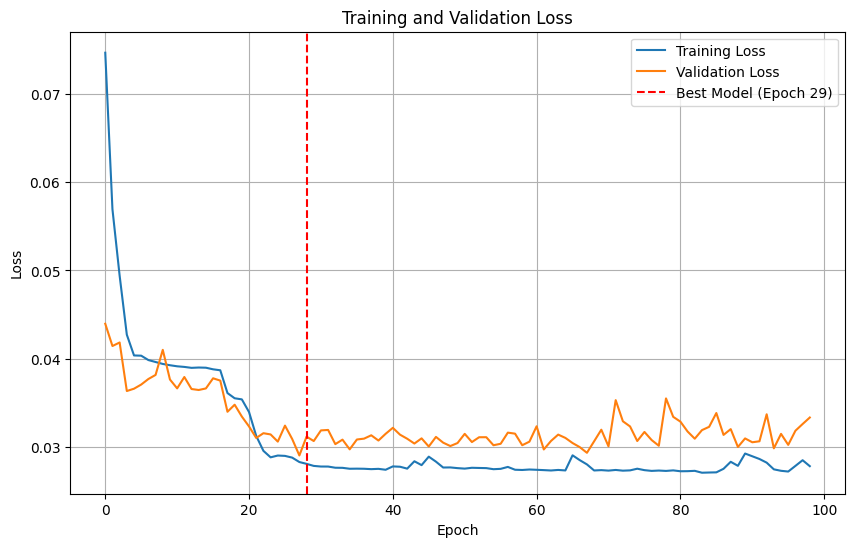

In [12]:
# Graficar las pérdidas
plot_losses(train_losses[1:], val_losses[1:], best_epoch)

In [13]:
# Evaluar en el conjunto de validación
val_loss = evaluate_model(model, val_loader)
print(f"Validation Loss: {val_loss:.4f}")

# Evaluar en el conjunto de prueba
test_loss = evaluate_model(model, test_loader)
print(f"Test Loss: {test_loss:.4f}")

Validation Loss: 0.0333
Test Loss: 0.0326


In [14]:
torch.save(model, "../Data/Models/Simple_NN.pth")
print("Modelo completo guardado correctamente en 'simple_nn_complete.pth'.")

Modelo completo guardado correctamente en 'simple_nn_complete.pth'.


In [15]:
# Cargar el modelo completo
model = torch.load(model_path)
model.eval()  # Configurar el modelo en modo evaluación

print("Modelo cargado correctamente desde 'simple_nn_complete.pth'.")

Modelo cargado correctamente desde 'simple_nn_complete.pth'.


C:\Users\Brian_iq\AppData\Local\Temp\ipykernel_25956\2703897339.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


In [16]:
from utils.metrics import Metric


def generate_trajectories_with_masks(model, dataloader):
    """
    Genera trayectorias estructuradas `(d, t, x, y)` utilizando las máscaras para
    filtrar los valores válidos.

    Args:
        model: Modelo entrenado.
        dataloader (DataLoader): DataLoader con los datos normalizados.

    Returns:
        tuple: Diccionarios con trayectorias predichas y reales estructuradas por usuario.
    """
    model.eval()
    device = next(model.parameters()).device

    predictions_per_user = {}
    validation_per_user = {}

    with torch.no_grad():
        for X, y, input_mask, target_mask in dataloader:
            # Mover datos al dispositivo
            X, y, target_mask = X.to(device), y.to(device), target_mask.to(device)

            # Obtener predicciones del modelo
            preds = model(X).cpu().numpy()  # [batch_size, 336, 2]
            y = y.cpu().numpy()  # [batch_size, 336, 2]
            target_mask = target_mask.cpu().numpy()  # [batch_size, 336, 2]

            # Extraer información relevante de X
            batch_size, seq_len, _ = X.shape
            uids = X[:, :, 0].cpu().numpy().astype(int)  # UID del usuario
            days = X[:, :, 1].cpu().numpy()  # Días
            timeslots = X[:, :, 2].cpu().numpy()  # Timeslots

            for i in range(batch_size):
                uid = uids[i, 0]  # El UID es constante en la secuencia
                pred_traj = []
                actual_traj = []

                for j in range(seq_len):
                    if target_mask[i, j, 0]:  # Verificar si el valor es válido
                        pred_point = preds[i, j]
                        target_point = y[i, j]

                        pred_traj.append(
                            (
                                days[i, j],  # Día
                                timeslots[i, j],  # Timeslot
                                pred_point[0],  # Coordenada x
                                pred_point[1],  # Coordenada y
                            )
                        )

                        actual_traj.append(
                            (
                                days[i, j],  # Día
                                timeslots[i, j],  # Timeslot
                                target_point[0],  # Coordenada x
                                target_point[1],  # Coordenada y
                            )
                        )

                if uid not in predictions_per_user:
                    predictions_per_user[uid] = []
                    validation_per_user[uid] = []

                predictions_per_user[uid].append(pred_traj)
                validation_per_user[uid].append(actual_traj)

    return predictions_per_user, validation_per_user


def evaluate_metrics_with_masks(
    model,
    dataloader,
    metrics: list[Metric],
    scaler,
    feature_columns=["d", "t", "x", "y"],
):
    """
    Evalúa métricas utilizando trayectorias estructuradas desde el DataLoader y máscaras.

    Args:
        model: Modelo entrenado.
        dataloader (DataLoader): DataLoader con los datos normalizados.
        metrics (list[Metric]): Lista de métricas a calcular.
        scaler (MinMaxScaler): Escalador utilizado para normalizar y revertir la normalización.
        feature_columns (list): Columnas utilizadas para normalización/desnormalización.

    Returns:
        dict: Diccionario con los resultados de las métricas.
    """
    # Generar trayectorias estructuradas con máscaras
    predictions_per_user, validation_per_user = generate_trajectories_with_masks(
        model, dataloader
    )

    # Desnormalizar y convertir a enteros las trayectorias
    def denormalize_trajectories(trajectories, scaler):
        denormalized = {}
        for uid, traj_list in trajectories.items():
            denormalized[uid] = []
            for traj in traj_list:
                denormalized_traj = []
                for point in traj:
                    d, t, x, y = point
                    denormalized_point = scaler.inverse_transform([[d, t, x, y]])[0]
                    denormalized_traj.append(
                        (
                            int(round(denormalized_point[0])),  # Día (entero)
                            int(round(denormalized_point[1])),  # Timeslot (entero)
                            int(round(denormalized_point[2])),  # Coordenada x (entero)
                            int(round(denormalized_point[3])),  # Coordenada y (entero)
                        )
                    )
                denormalized[uid].append(denormalized_traj)
        return denormalized

    # Desnormalizar predicciones y validaciones
    predictions_per_user = denormalize_trajectories(predictions_per_user, scaler)
    validation_per_user = denormalize_trajectories(validation_per_user, scaler)

    # Calcular métricas
    results = {metric.__class__.__name__: [] for metric in metrics}

    # Iterar sobre todos los usuarios en las predicciones
    for uid in predictions_per_user.keys():
        if uid in validation_per_user:
            # Extraer las secciones para este usuario
            user_predictions = predictions_per_user[uid]
            user_validation = validation_per_user[uid]

            # Calcular las métricas para este usuario
            for metric in metrics:
                score = metric.calculate(user_predictions, user_validation)
                results[metric.__class__.__name__].append(score)
        else:
            print(f"Usuario {uid} no encontrado en las validaciones.")

    # Calcular el promedio de las métricas para todos los usuarios
    average_results = {
        metric_name: np.mean(scores) if scores else 0.0
        for metric_name, scores in results.items()
    }

    # Mostrar resultados
    for metric_name, avg_score in average_results.items():
        print(f"{metric_name}: {avg_score}")


    # return results

In [ ]:
from utils.metrics import DTWMetric, GeoBLEUMetric, LPPMetric, MAEMetric

# Instanciar métricas
metrics_instances = [
    LPPMetric(),
    MAEMetric(),
    GeoBLEUMetric(),
    DTWMetric(),
]
# Todo Mirar el testloader a ver xq es que hay pocas targets  y verificar sis e estan creando todas las seciencias en el target
# Evaluar métricas
evaluate_metrics_with_masks(
    model, test_loader, metrics_instances, scaler=global_scaler
)

LPPMetric: 0.4534
MAEMetric: 44.3860
GeoBLEUMetric: 0.0004
DTWMetric: 320.9399


In [16]:
# torch.save(model, "../Data/Models/Simple_NN.pth")
# print("Modelo completo guardado correctamente en 'simple_nn_complete.pth'.")

Modelo completo guardado correctamente en 'simple_nn_complete.pth'.
